# Eye Diseases Classification Dataset

#### Import required libraries, and load the dataset

In [17]:
import numpy as np
import pandas as pd
import tensorflow as tf

train_ds = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/eye-diseases-classification/dataset', 
    label_mode='categorical',
    batch_size=128,
    image_size=(200, 200),
    validation_split=0.2, 
    subset='training', 
    seed=123
)

validate_ds = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/eye-diseases-classification/dataset', 
    label_mode='categorical',
    batch_size=128,
    image_size=(200, 200),
    validation_split=0.2, 
    subset='validation', 
    seed=123
)

validate_batches = tf.data.experimental.cardinality(validate_ds)
test_ds = validate_ds.take(validate_batches // 2)
validate_ds = validate_ds.skip(validate_batches // 2)

normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
validate_ds = validate_ds.map(lambda x, y: (normalization_layer(x), y))

Found 4217 files belonging to 4 classes.
Using 3374 files for training.
Found 4217 files belonging to 4 classes.
Using 843 files for validation.


In [18]:
class_names = train_ds.class_names
print(class_names)

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']


### Visualize the data

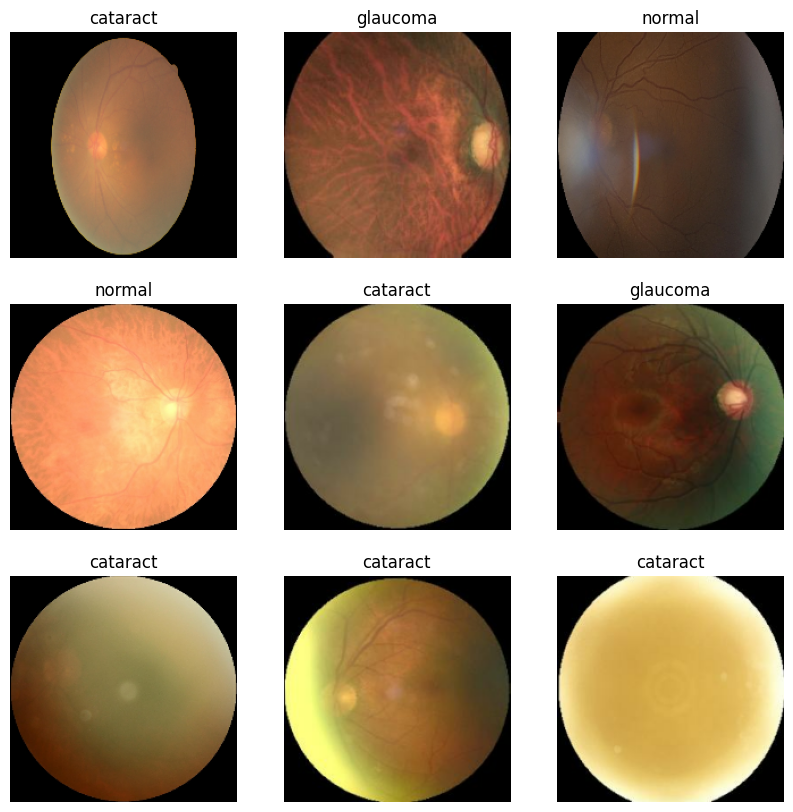

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[list(labels[i]).index(1)])
        plt.axis("off")

### Baseline Model

Create a baseline model without regularization penalties applied to the layers, or dropout used to prevent overfitting.

In [20]:
model_base = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(200, 200, 3)),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

model_base.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 120000)            0         
                                                                 
 dense (Dense)               (None, 50)                6000050   
                                                                 
 dense_1 (Dense)             (None, 100)               5100      
                                                                 
 dense_2 (Dense)             (None, 4)                 404       
                                                                 
Total params: 6,005,554
Trainable params: 6,005,554
Non-trainable params: 0
_________________________________________________________________


In [21]:
model_base.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [22]:
history = model_base.fit(
    normalized_ds,
    epochs=20,
    validation_data=validate_ds
)

Epoch 1/20
27/27 [==============================] - 19s 551ms/step - loss: 6.7893 - accuracy: 0.3503 - val_loss: 1.3766 - val_accuracy: 0.4641
Epoch 2/20
27/27 [==============================] - 19s 554ms/step - loss: 1.0480 - accuracy: 0.5605 - val_loss: 0.9023 - val_accuracy: 0.5251
Epoch 3/20
17/27 [=================>............] - ETA: 5s - loss: 0.8535 - accuracy: 0.5983

KeyboardInterrupt: 

In [ ]:
results = model_base.evaluate(test_ds)

In [ ]:
def plot_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Val'], loc='upper left')

    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Val'], loc='upper left')

    fig.show()

In [ ]:
plot_history(history)

### Second Model

Add Dropout layer and kernel regularizers to reduce the gap between training and validation accuracy.

In [ ]:
model_optimize = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(200, 200, 3)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-5)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-5)),    
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')
])

model_optimize.summary()

In [ ]:
model_optimize.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history_optimizer = model_optimize.fit(
    normalized_ds,
    epochs=20,
    validation_data=validate_ds
)

In [ ]:
plot_history(history_optimizer)

### Third Model

Create a Convolutional Neural Network (CNN) to improve the accuracy for our image classification model. 

In [ ]:
cnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(40, (3, 3), activation='relu', input_shape=(200, 200, 3)),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Conv2D(50, (3, 3), activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(60, (3, 3)),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Conv2D(70, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4, activation='softmax')
])
cnn_model.summary()

In [ ]:
cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
cnn_history = cnn_model.fit(
    normalized_ds,
    epochs=5,
    validation_data=validate_ds
)

In [ ]:
plot_history(cnn_history)